## GPcounts with zero-inflated negative binomial likelihood

Nuha BinTayyash, 2020

This notebook comapre GPcount fit with zero-inflated negative binomial, negative binomial and Gaussian likelihoods on ScRNA-seq gene expression data for highly expressed genes in Islet $\alpha$ cell from [GSE8737 single cell RNA-seq ](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE87375) dataset.

In [1]:
import pandas as pd
import numpy as np
import gpflow 

Load $\alpha$ dataset and pseudotime information

In [2]:
Y = pd.read_csv('alpha_counts.csv',index_col=[0])
X = pd.read_csv('alpha_time_points.csv',index_col=[0])

#### Fit GPcount with zero inflated negative binomial likelihood

In [3]:
from GPcounts.GPcounts_Module import Fit_GPcounts

In [4]:
gene_name = ['Fam184b','Pde1a']
gp_counts = Fit_GPcounts(X,Y.loc[gene_name]) 

Probabilty of zeros in Fam184b and Pde1a genes

In [5]:
Y.loc[gene_name][Y.loc[gene_name] == 0].count(axis=1)/len(Y.columns)

Symbol
Fam184b    0.862805
Pde1a      0.689024
dtype: float64

In [6]:
from matplotlib import pyplot as plt
import statsmodels.api as sm

def plot(Sparse = False):
    plt.tick_params(labelsize='large', width=2)     
    plt.ylabel('Gene Expression', fontsize=16)
    plt.xlabel('Times', fontsize=16)
    c = 'royalblue'
    
    if model_index == 3:
        c = 'green'
    
    plt.plot(xtest, mean,color= c, lw=2) 
    
    if likelihood == 'Gaussian':
        y = np.log(Y.loc[indexes[i]]+1)
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 1*np.sqrt(var[:,0]),
                            mean[:,0] + 1*np.sqrt(var[:,0]),color=c,alpha=0.2) # one standard deviation
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 2*np.sqrt(var[:,0]),
                            mean[:,0] + 2*np.sqrt(var[:,0]),color=c, alpha=0.1)# two standard deviation
    else:
        y = Y.loc[indexes[i]]
        lowess = sm.nonparametric.lowess    
        # one standard deviation 68%
        percentile_16 = lowess(np.percentile(var, 16, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_16 = [(i > 0) * i for i in percentile_16]
        percentile_84 = lowess(np.percentile(var, 84, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_84 = [(i > 0) * i for i in percentile_84]
        plt.fill_between(xtest[:,0],percentile_16,percentile_84,color=c,alpha=0.2)
        
        # two standard deviation 95%
        percentile_5 = lowess(np.percentile(var, 5, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_5 = [(i > 0) * i for i in percentile_5]
        percentile_95 = lowess(np.percentile(var,95, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_95 = [(i > 0) * i for i in percentile_95]
        plt.fill_between(xtest[:,0],percentile_5,percentile_95,color=c,alpha=0.1)
    
    if test == 'Two_samples_test' and model_index == 1:
        plt.scatter(X[0:int(X.shape[0]/2)],Y.loc[indexes[i]][0:int(X.shape[0]/2)], s=30, marker='o', color= 'royalblue',alpha=1.) #data    
        plt.scatter(X[int(X.shape[0]/2)::],Y.loc[indexes[i]][int(X.shape[0]/2)::], s=30, marker='o', color= 'green',alpha=1.) #data

    else: 
        plt.scatter(X,y,s=30,marker = 'o',color=c,alpha=1.)
    
    if Sparse:
        inducing_points = model.inducing_variable.Z.numpy()
        inducing_points = inducing_points[inducing_points >= np.min(X.values)]
        inducing_points = inducing_points[inducing_points <= np.max(X.values)]
        
        k = []
        for key in inducing_points:
             k.append(X.iloc[(X[X.columns[0]]-key).abs().argsort()[:1]].index.values.tolist()[0])
     
        plt.scatter(inducing_points,y[k],s=30,marker = 'o',color='red',alpha=1.) 
        
    if not(test == 'Two_samples_test' and model_index == 2):
        plt.show()
    

In [7]:
likelihood = 'Zero_inflated_negative_binomial' 
log_likelihoods = gp_counts.Infer_trajectory(likelihood)
log_likelihoods

100%|██████████| 2/2 [00:54<00:00, 27.29s/it]


,Dynamic_model_log_likelihood,time,failure counter
Fam184b,-295.271088,0:00:35.719166,0
Pde1a,-598.080225,0:00:18.841339,0


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Fam184b


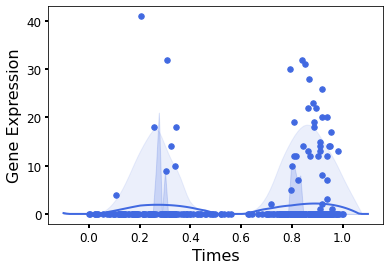

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,4.107289447417649
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.18547955657603368
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.31694470352834336
VGP.likelihood.km,Parameter,Softplus,,True,(),float64,82.15828686652759
VGP.q_mu,Parameter,,,True,"(328, 1)",float64,[[8.89508677e-02...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 328, 328)",float64,"[[[5.00132902e-01, 0.00000000e+00, 0.00000000e+00..."


Pde1a


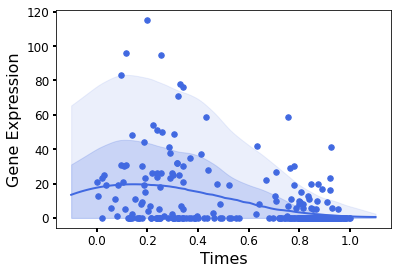

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,6.333817452543167
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.9454829278335664
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.8415409100782165
VGP.likelihood.km,Parameter,Softplus,,True,(),float64,30.9210878909264
VGP.q_mu,Parameter,,,True,"(328, 1)",float64,[[1.37900588e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 328, 328)",float64,"[[[9.16870265e-02, 0.00000000e+00, 0.00000000e+00..."


In [8]:
likelihood = 'Zero_inflated_negative_binomial' 
indexes = log_likelihoods.index.values.tolist() # list of genes to be plotted 
test = 'Infer_trajectory' # name of the test
xtest = np.linspace(np.min(X.values)-.1,np.max(X.values)+.1,100)[:,None]

params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot()
        model_index = model_index + 1
        gpflow.utilities.print_summary(model, fmt='notebook')
        

In [9]:
Sparse = True
gp_counts = Fit_GPcounts(X,Y.loc[gene_name],sparse = Sparse)
likelihood = 'Zero_inflated_negative_binomial' 
log_likelihoods = gp_counts.Infer_trajectory(likelihood)
log_likelihoods

100%|██████████| 2/2 [00:24<00:00, 12.39s/it]


,Dynamic_model_log_likelihood,time,failure counter
Fam184b,-295.272422,0:00:20.853035,0
Pde1a,-598.079842,0:00:03.919687,0


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Fam184b


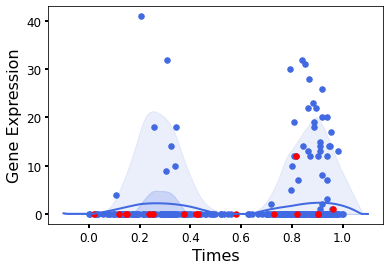

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,4.034496478270893
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.1849666188748751
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.3168434576612784
SVGP.likelihood.km,Parameter,Softplus,,True,(),float64,81.56014944464063
SVGP.inducing_variable.Z,Parameter,,,True,"(16, 1)",float64,[[0.02080325...
SVGP.q_mu,Parameter,,,True,"(16, 1)",float64,[[0.19961758...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[4.42759328e-01, 0.00000000e+00, 0.00000000e+00..."


Pde1a


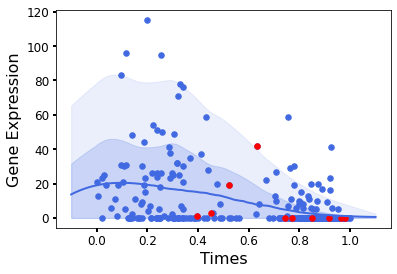

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,6.4243558197899855
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.9477101634915395
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.8403780615711117
SVGP.likelihood.km,Parameter,Softplus,,True,(),float64,31.056083683998324
SVGP.inducing_variable.Z,Parameter,,,True,"(16, 1)",float64,[[-0.5894645...
SVGP.q_mu,Parameter,,,True,"(16, 1)",float64,[[8.69872029e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[4.25311906e-01, 0.00000000e+00, 0.00000000e+00..."


In [10]:
likelihood = 'Zero_inflated_negative_binomial' 
indexes = log_likelihoods.index.values.tolist() # list of genes to be plotted 
test = 'Infer_trajectory' # name of the test
xtest = np.linspace(np.min(X.values)-.1,np.max(X.values)+.1,100)[:,None]

params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot(Sparse)
        model_index = model_index + 1
        gpflow.utilities.print_summary(model, fmt='notebook')
        

#### Fit GPcount with negative binomial likelihood

In [11]:
likelihood = 'Negative_binomial' 
log_likelihoods= gp_counts.Infer_trajectory(likelihood)
log_likelihoods

100%|██████████| 2/2 [00:06<00:00,  3.17s/it]


,Dynamic_model_log_likelihood,time,failure counter
Fam184b,-316.896192,0:00:03.623016,0
Pde1a,-642.953427,0:00:02.698701,0


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Fam184b


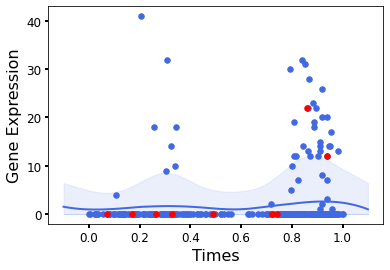

Pde1a


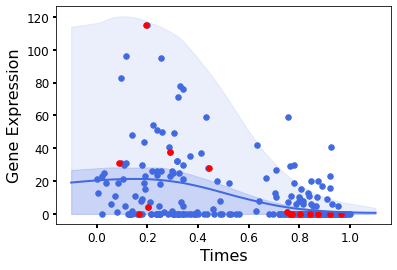

In [12]:
likelihood = 'Negative_binomial'
params = gp_counts.load_models(indexes,test,xtest,likelihood)
for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot(Sparse)
        model_index = model_index + 1

#### Fit GPcount with Gaussian likelihood

In [13]:
likelihood = 'Gaussian'
log_likelihoods = gp_counts.Infer_trajectory(likelihood)
log_likelihoods

100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


,Dynamic_model_log_likelihood,time,failure counter
Fam184b,-442.142384,0:00:01.448353,0
Pde1a,-537.039612,0:00:01.138055,0


100%|██████████| 2/2 [00:00<00:00, 30.20it/s]


Fam184b


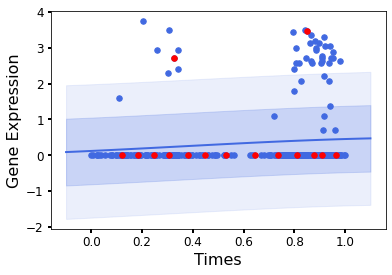

Pde1a


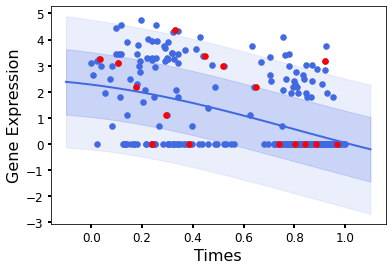

In [14]:
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot(Sparse)
        model_index = model_index + 1